# Standardized Coupled Structural Causal Models

Here, we showcase how we standardize coupled structural causal models.

In [1]:
# Autoreload extension
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import torch
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl

from causaldynamics.utils import set_rng_seed
from causaldynamics.initialization import initialize_weights, initialize_biases, initialize_x
from causaldynamics.scm import create_scm_graph, get_root_nodes_mask, GNR
from causaldynamics.mlp import propagate_mlp
from causaldynamics.systems import solve_system
from causaldynamics.plot import plot_trajectories, plot_scm, plot_3d_trajectories

Let's create a minimal SCM with 2 nodes that has a Lorenz system located on the driving node. We then create two distinct time-series by propagating the Lorenz driver through this minimal SCM (i) without standardization and (ii) with standardization.

In [3]:
# This takes a while to run...
# Set parameters
set_rng_seed(1337)
num_nodes = 2
num_timesteps = 1000
dimensions = 3

# Sample the SCM, all hyperoparameters and propagate the Lorenz attractor through the SCM
A = GNR(num_nodes).generate()
root_nodes = get_root_nodes_mask(A)
W = initialize_weights(num_nodes, dimensions)
b = initialize_biases(num_nodes, dimensions)
init = solve_system(num_timesteps, num_nodes, "Lorenz")

init_ns = initialize_x(init, A, standardize=False)
x = propagate_mlp(A, W, b, init=init_ns)
da = xr.DataArray(x, dims=['time', 'node', "dim"])

init_s = initialize_x(init, A, standardize=True)
x_s = propagate_mlp(A, W, b, init=init_s, standardize=True)
da_s = xr.DataArray(x_s, dims=['time', 'node', "dim"])

Let's plot the results.

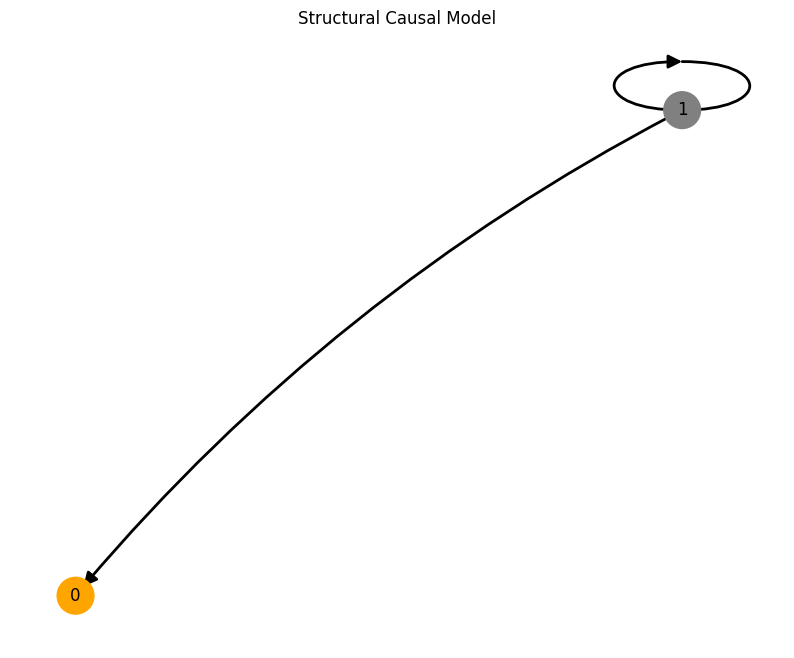

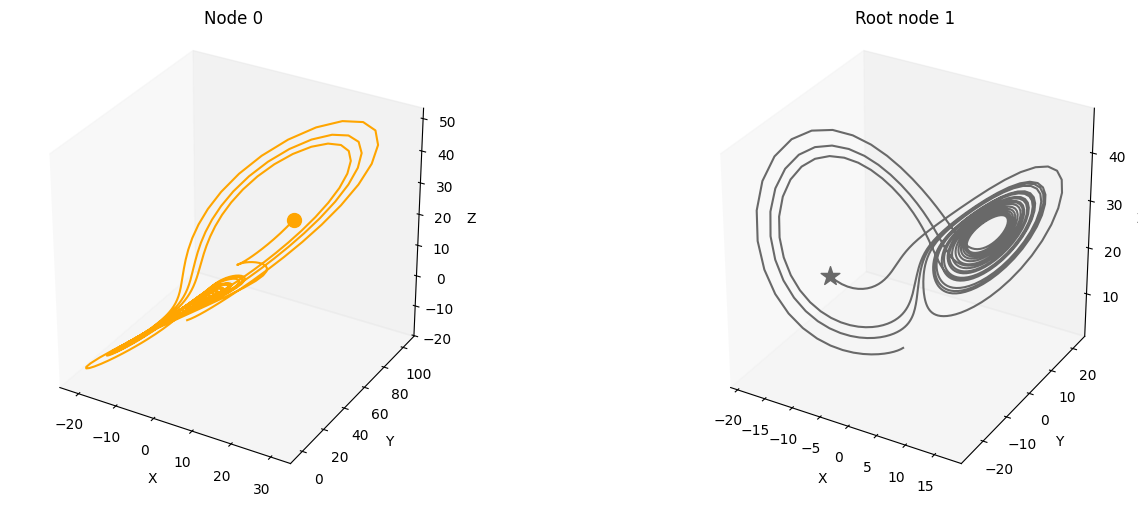

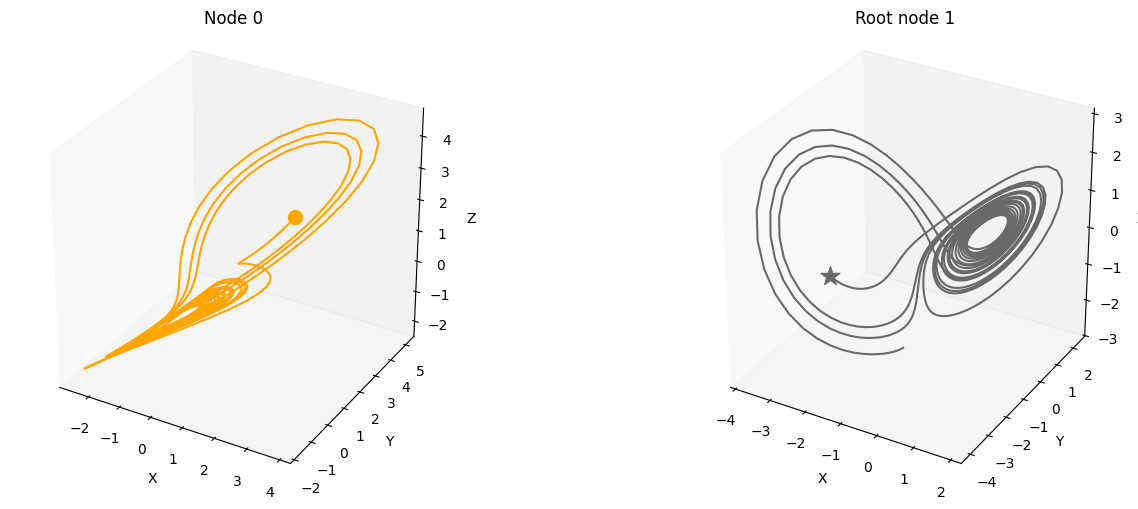

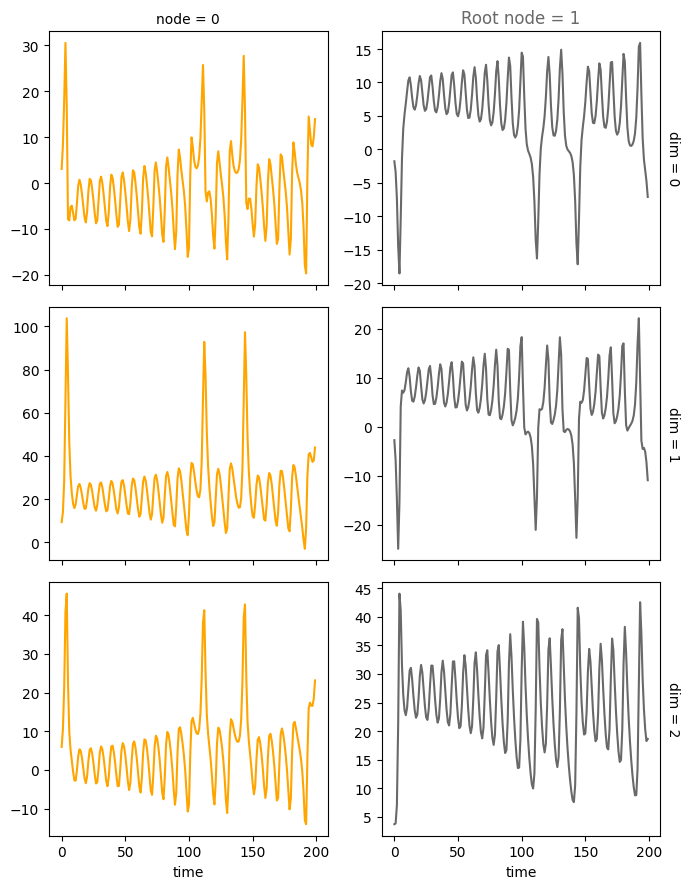

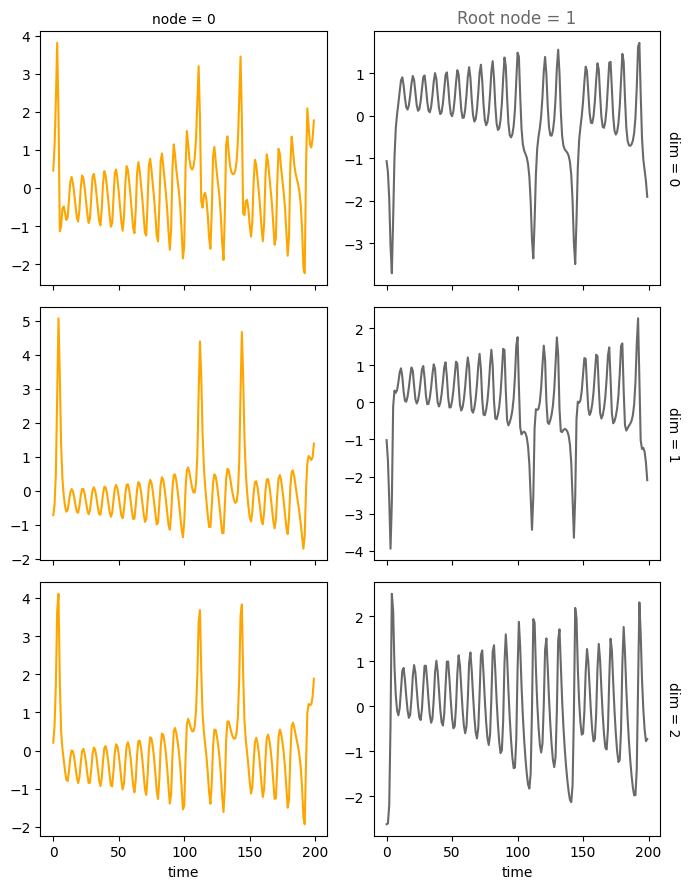

In [4]:
### Visualize the results
# Plot the SCM graph
plot_scm(G=create_scm_graph(A), root_nodes=root_nodes)

# Plot the trajectories in 3D
plot_3d_trajectories(da, root_nodes)
plot_3d_trajectories(da_s, root_nodes)

# Plot the trajectories in 2D
plot_trajectories(da.isel(time=slice(0, 1000, 5)), root_nodes, sharey=False)
plot_trajectories(da_s.isel(time=slice(0, 1000, 5)), root_nodes, sharey=False)


As we can see, the propagated signal in the non-standardized version structurally resembles the driver. In contrast, in the standardized version, the signal propagated through the minimal graph does not resemble the original signal. However, we can observe that the signal remains in a similar y-axis limit range. This would be expected when standard normalizing the signal at each time step.

Let's now look at a linear chain with 5 nodes and how the signal propagates through it.

In [5]:
# This takes a while to run...
# Set parameters
set_rng_seed(1337)
num_nodes = 5
num_timesteps = 1000
node_dim = 3

A = torch.tensor([[0,0,0,0,0],
                  [1,0,0,0,0],
                  [0,1,0,0,0],
                  [0,0,1,0,0],
                  [0,0,0,1,0]])
W = initialize_weights(num_nodes, node_dim)
b = initialize_biases(num_nodes, node_dim)
init = solve_system(num_timesteps, num_nodes, "Lorenz")
init_ns = initialize_x(init, A, standardize=False)
init_s = initialize_x(init, A, standardize=True)
x = propagate_mlp(A, W, b, init=init_ns)
x_s = propagate_mlp(A, W, b, init=init_s, standardize=True)
root_nodes = get_root_nodes_mask(A)
da = xr.DataArray(x, dims=['time', 'node', "dim"])
da_s = xr.DataArray(x_s, dims=['time', 'node', "dim"])

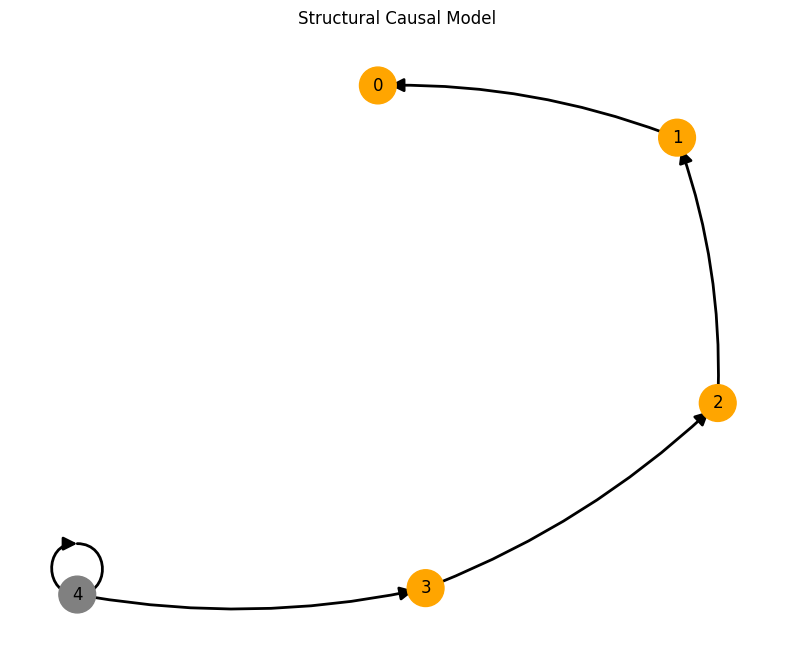

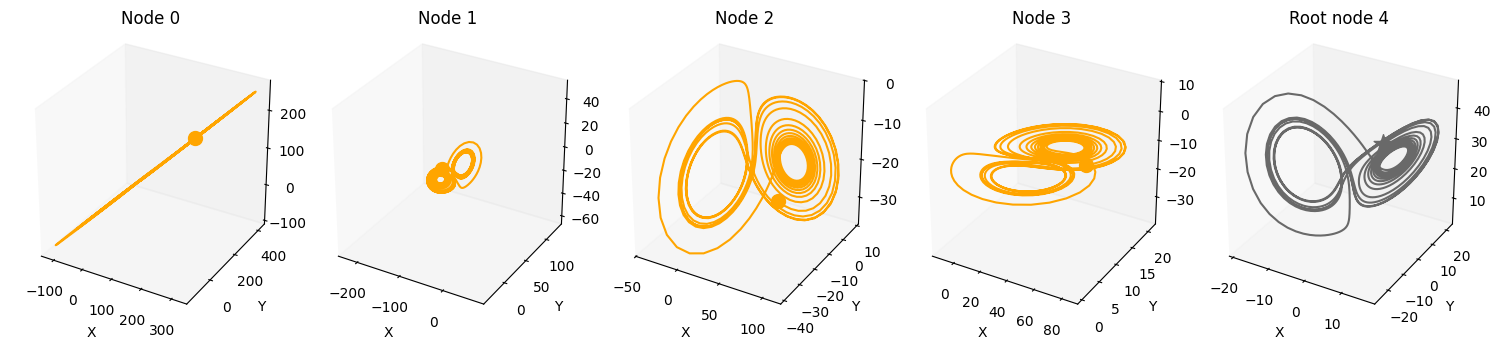

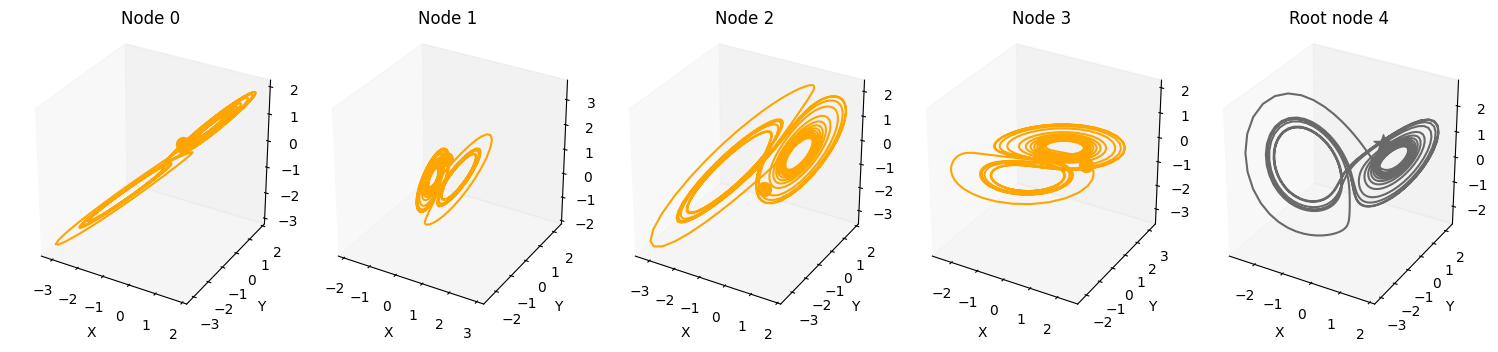

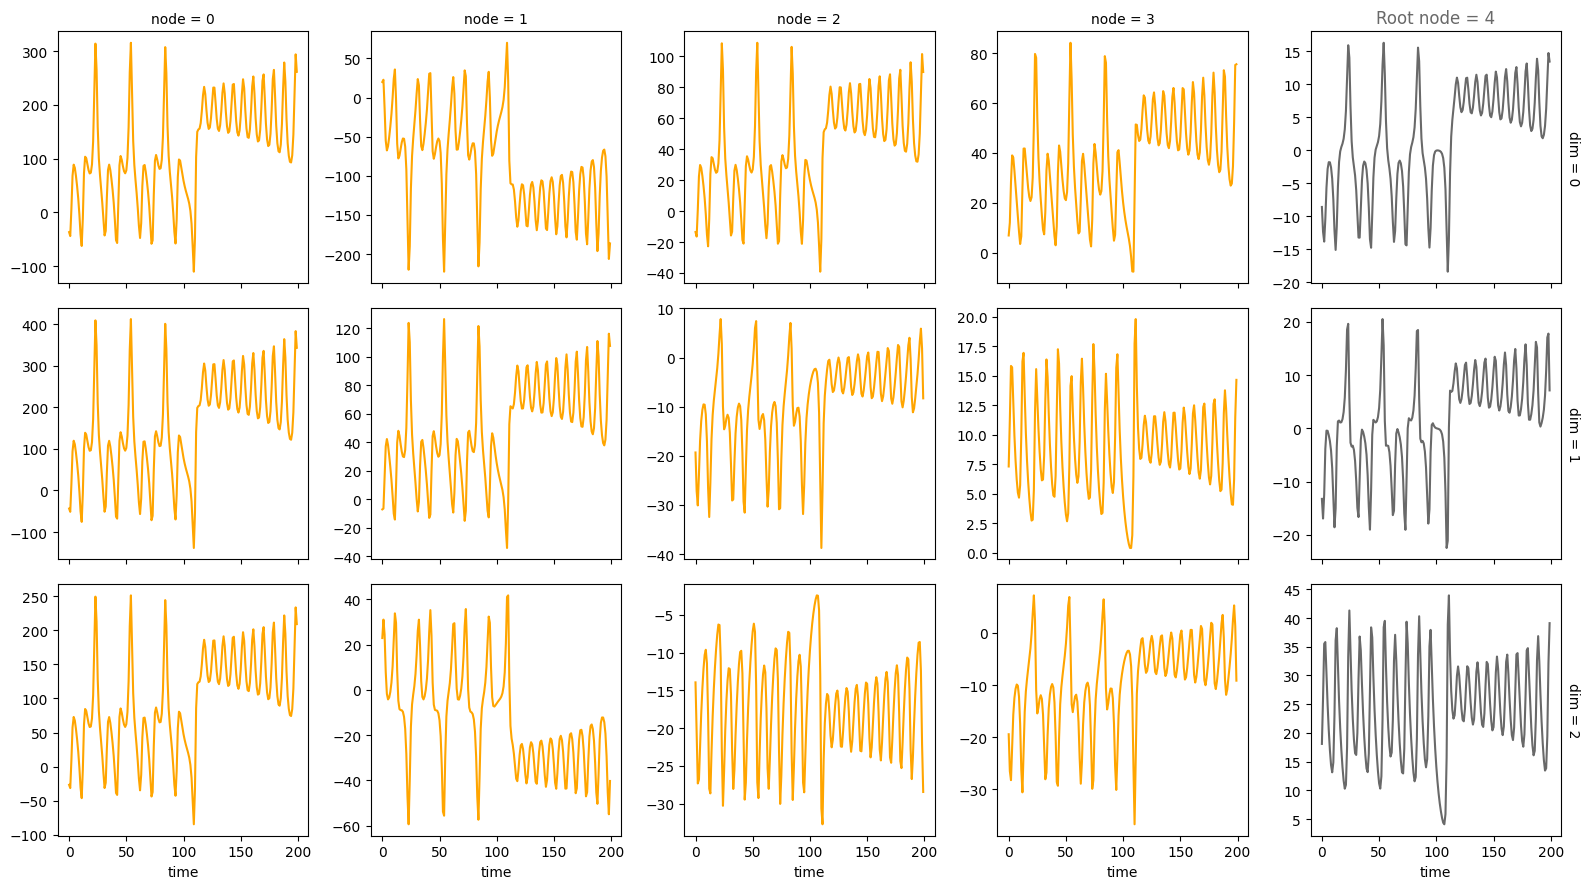

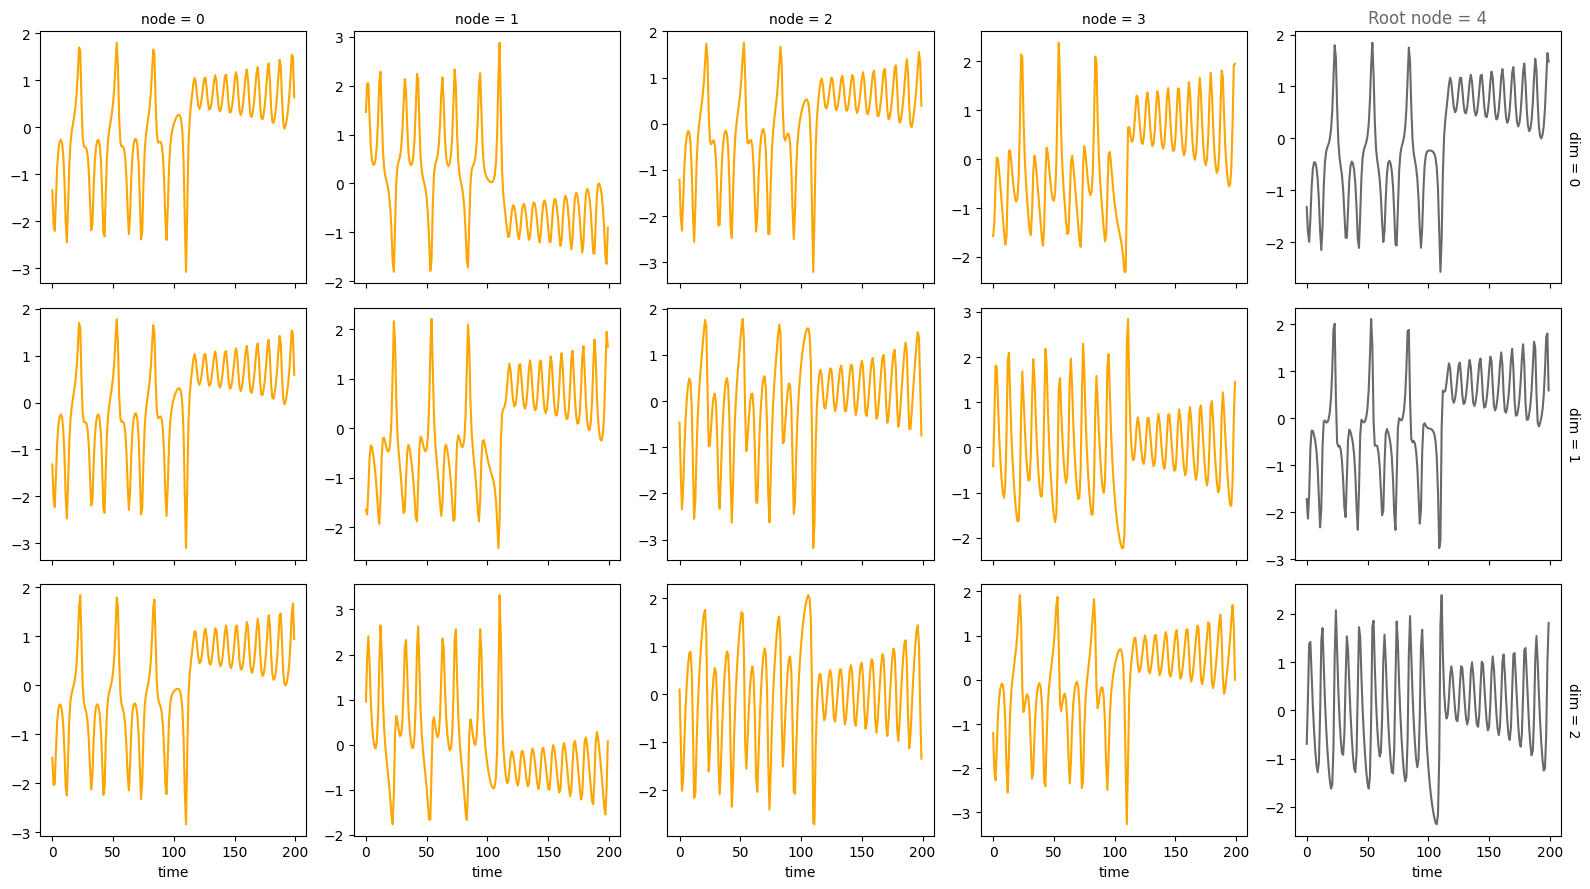

In [6]:
### Visualize the results
# Plot the SCM graph
plot_scm(G=create_scm_graph(A), root_nodes=root_nodes)

# Plot the trajectories in 3D
plot_3d_trajectories(da, root_nodes)
plot_3d_trajectories(da_s, root_nodes)

# Plot the trajectories in 2D
plot_trajectories(da.isel(time=slice(0, 1000, 5)), root_nodes, sharey=False)
plot_trajectories(da_s.isel(time=slice(0, 1000, 5)), root_nodes, sharey=False)

Let us look at the variance of the signal 

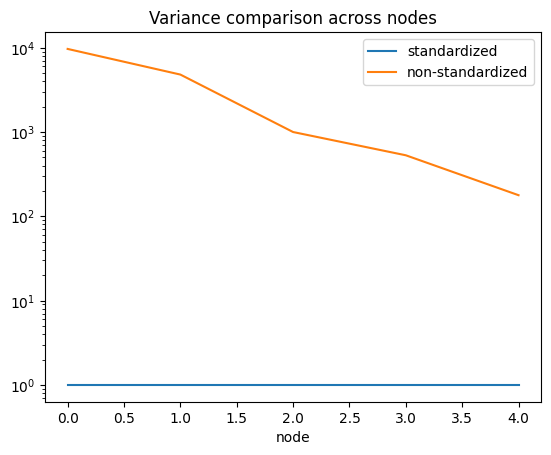

In [7]:
plt.figure()
da_s.var(dim=['time', 'dim']).plot(x='node', yscale='log', label='standardized')
da.var(dim=['time', 'dim']).plot(x='node', yscale='log', label='non-standardized')
plt.legend()
plt.title('Variance comparison across nodes')
plt.show()

Let's look at larger systems.

In [8]:
# This takes a while to run...
# Set parameters
set_rng_seed(24)
num_nodes = 10
num_timesteps = 1000
dimensions = 3

A = GNR(num_nodes).generate()
W = initialize_weights(num_nodes, dimensions)
b = initialize_biases(num_nodes, dimensions)
init = solve_system(num_timesteps, num_nodes, "Lorenz")
init_s = initialize_x(init, A, standardize=True)
x = propagate_mlp(A, W, b, init=init)
x_s = propagate_mlp(A, W, b, init=init_s, standardize=True)
root_nodes = get_root_nodes_mask(A)
da = xr.DataArray(x, dims=['time', 'node', "dim"])
da_s = xr.DataArray(x_s, dims=['time', 'node', "dim"])

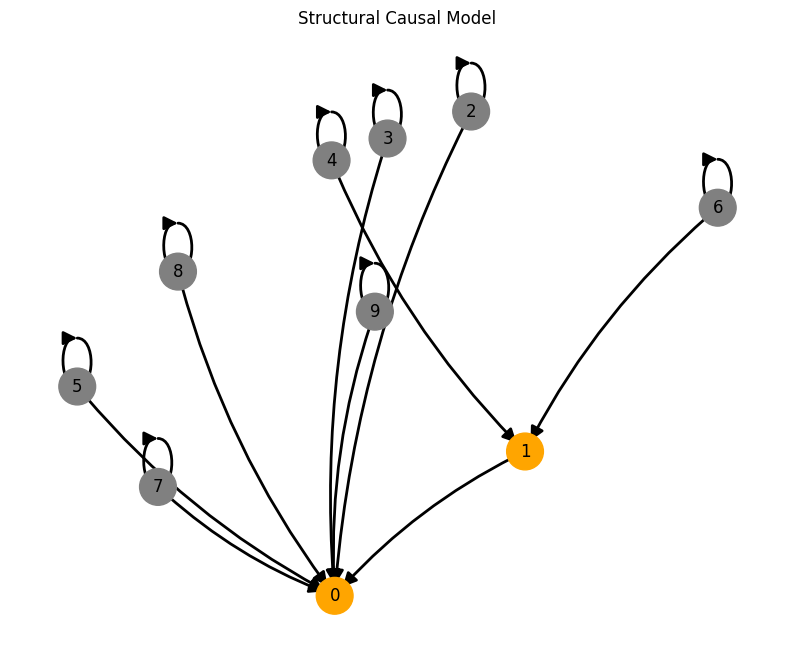

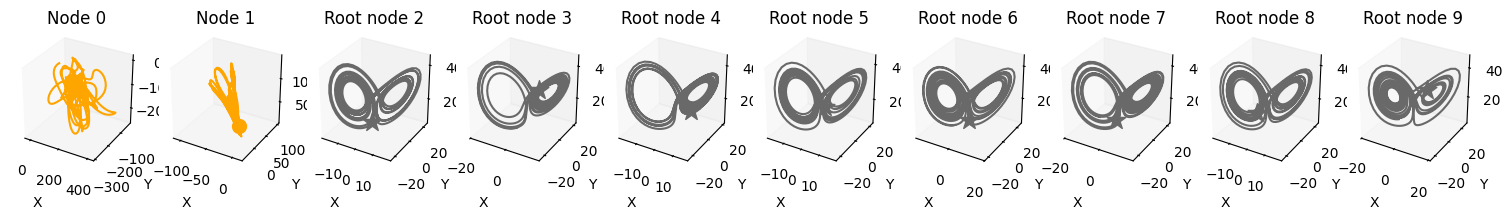

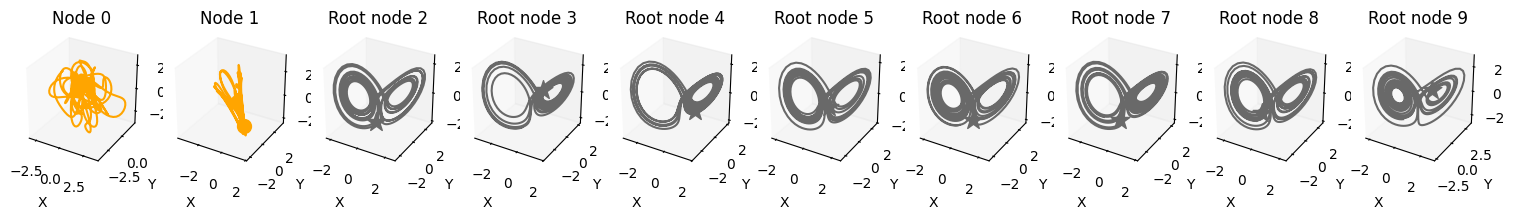

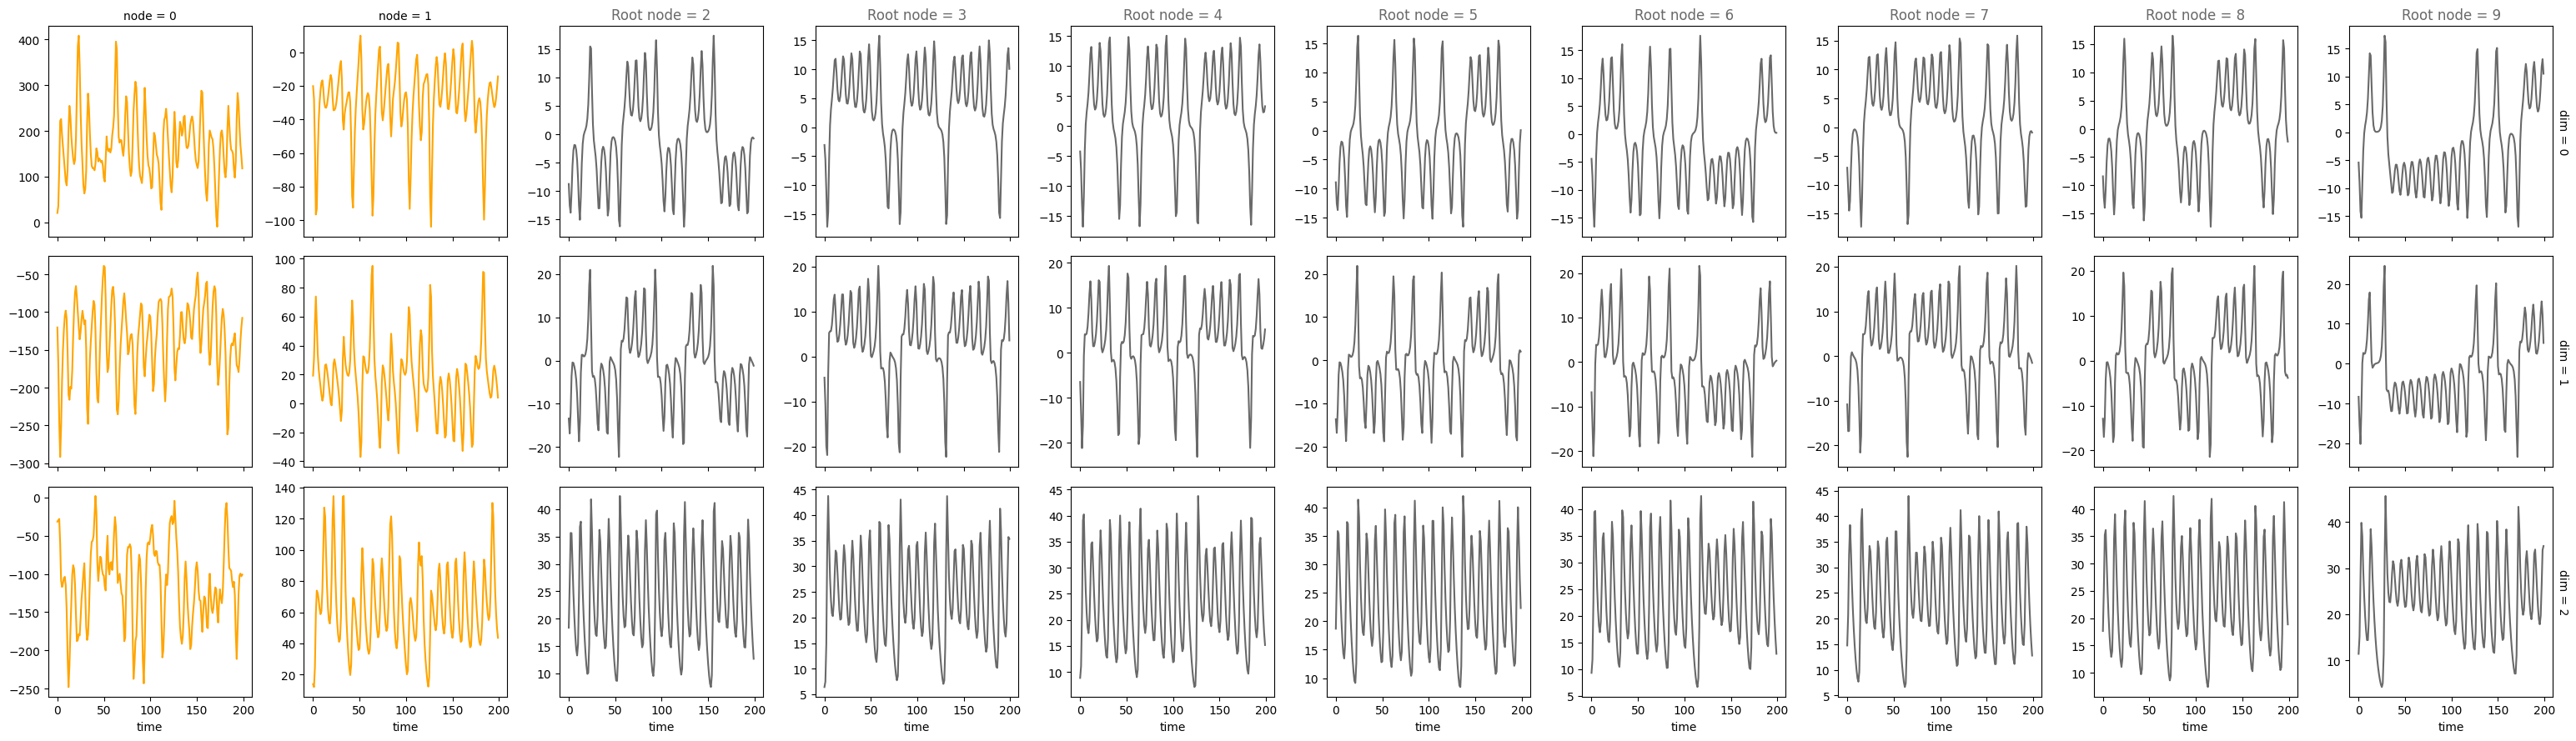

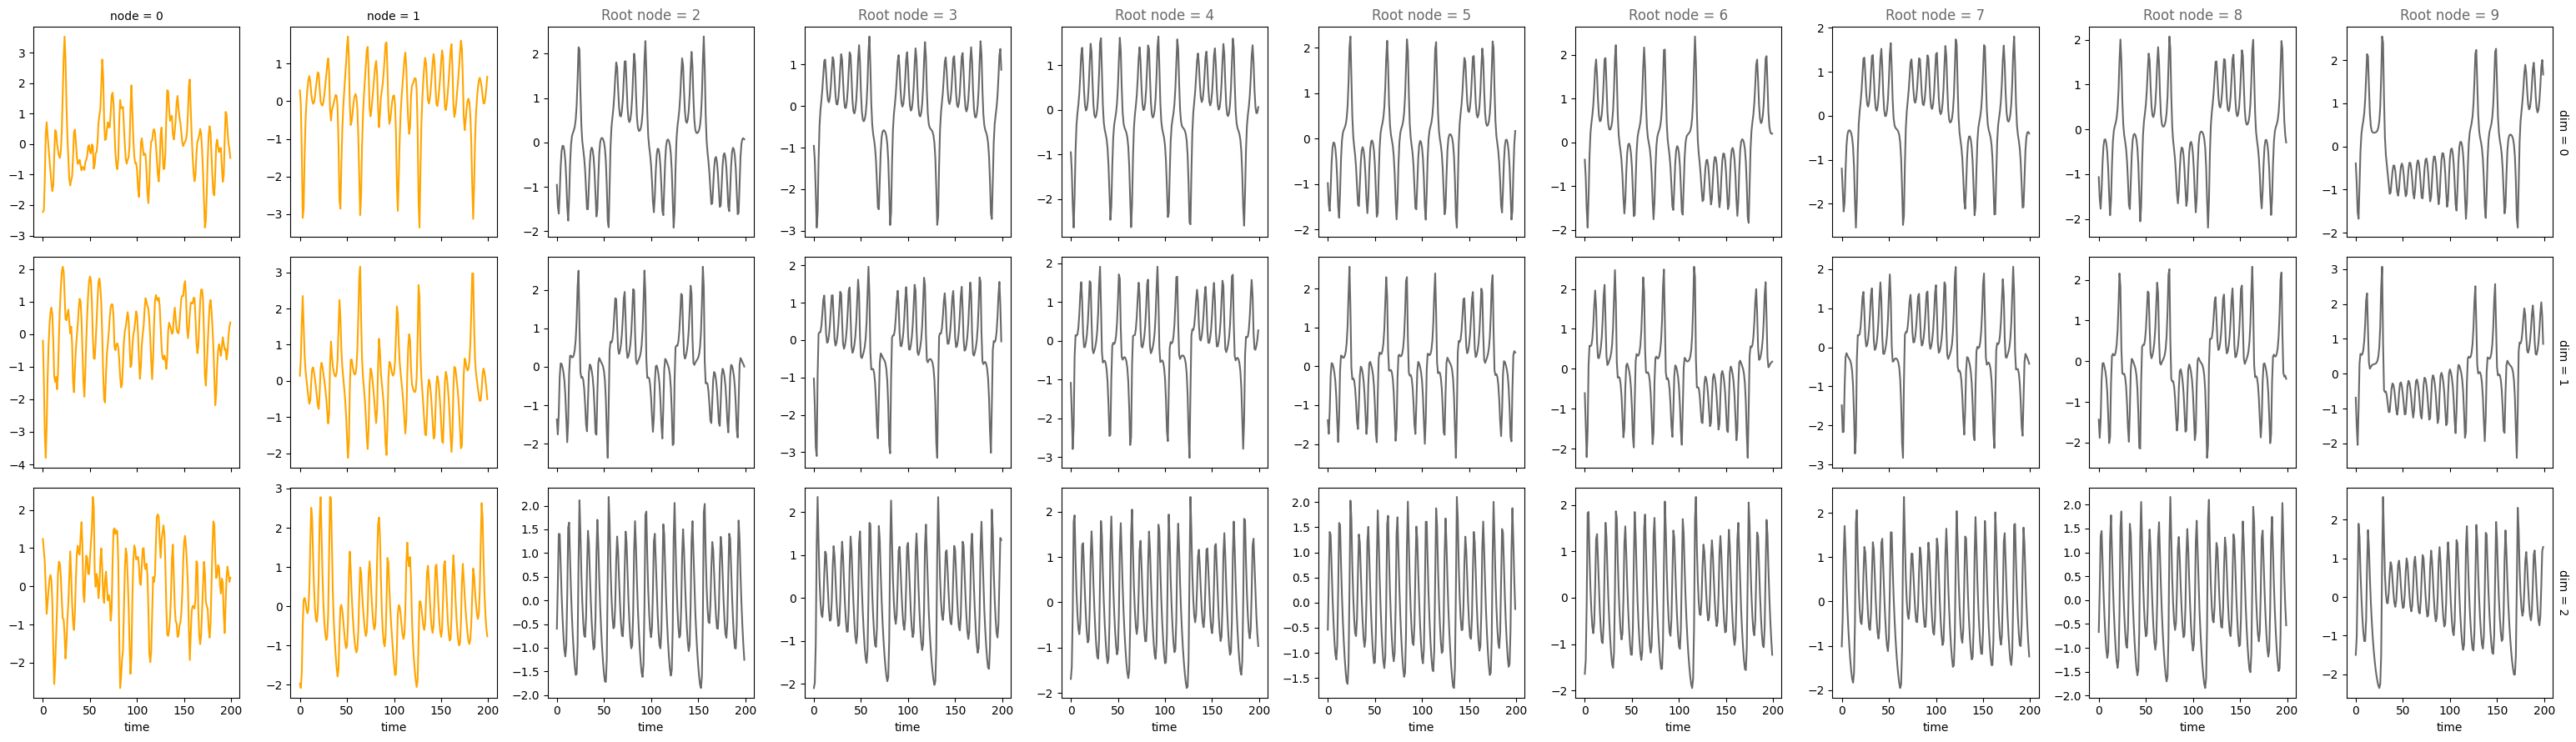

In [9]:
### Visualize the results
# Plot the SCM graph
plot_scm(G=create_scm_graph(A), root_nodes=root_nodes)

# Plot the trajectories in 3D
plot_3d_trajectories(da, root_nodes)
plot_3d_trajectories(da_s, root_nodes)

# Plot the trajectories in 2D
plot_trajectories(da.isel(time=slice(0, 1000, 5)), root_nodes, sharey=False)
plot_trajectories(da_s.isel(time=slice(0, 1000, 5)), root_nodes, sharey=False)

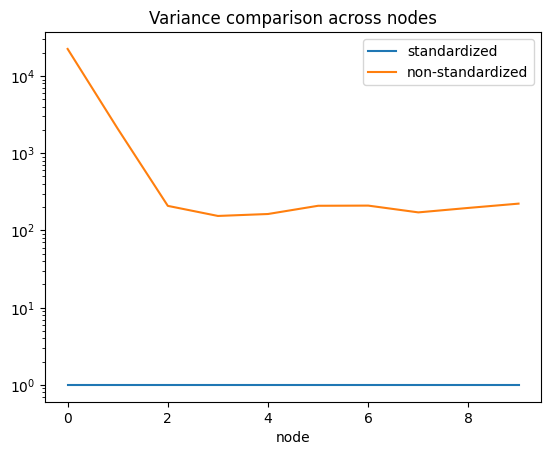

In [10]:
plt.figure()
da_s.var(dim=['time', 'dim']).plot(x='node', yscale='log', label='standardized')
da.var(dim=['time', 'dim']).plot(x='node', yscale='log', label='non-standardized')
plt.legend()
plt.title('Variance comparison across nodes')
plt.show()